### Парсинг данных и создание датафрейма

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

In [2]:
runN = "*" # If take all runs set runN = "*"
paths = glob.glob(f"build/Run{runN}_nt_ParticleData_t*.csv")

In [3]:
with open(paths[0], 'r') as f:
    print(f"Headers from file: {paths[0]}")

    hlines = []
    while True:
        line = f.readline()
        if len(line) == 0 or line[0] != '#':
            break
        hlines.append(line)
    title = hlines[1].replace('#title ', '')[:-1]
    sep = chr(int(hlines[2].replace('#separator ', '')[:-1]))
    vsc_sep = chr(int(hlines[3].replace('#vector_separator ', '')[:-1]))
    columns = [' '.join(l.split(' ')[2:])[:-1] for l in hlines[4:]]
    meta_len = len(hlines)
    # print(f'Metarows: {meta_len}\nColumns: {columns}')

Headers from file: build/Run0_nt_ParticleData_t8.csv


In [4]:
data = pd.DataFrame()
for path in paths:
    item = pd.read_csv(path, skiprows=meta_len, names=columns)
    data = pd.concat([data, item], ignore_index=True)

In [5]:
len(data)

94767872

In [ ]:
set(data['creator_process'])

e - elecron, Brem - тормозное излучение, Ionic - ионизационные потери (неупругое)

conv - обратная аннигилияция (фотоны в электроны и позитроны)

annihil - аннигилиция

phot - фотоэффект

In [ ]:
data.head()

In [6]:
filt = data
filt = filt[filt['parentID'] != 0] # Вторичные частицы
filt = filt[filt['creator_process'] != 'user']
filt = filt[filt['particle_name'] == 'e-'] # Вторичные электроны

In [7]:
len(filt)

83104551

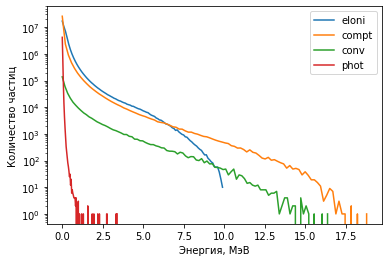

In [8]:
for process in ['eIoni', 'compt', 'conv', 'phot']:
    proc_data = filt[filt['creator_process'] == process]
    # n, e, _ = plt.hist(proc_data['energy'], bins=100)
    n, e = np.histogram(proc_data['energy'], bins=100)
    plt.plot(e[:-1], n, label=process) # 
plt.legend()
plt.yscale('log')
plt.ylabel('Количество частиц')
plt.xlabel('Энергия, МэВ')
plt.show()

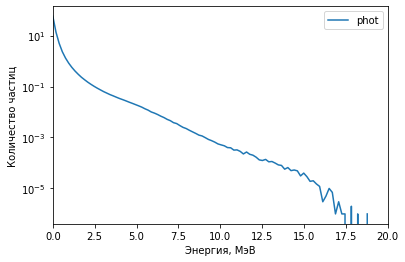

In [13]:
n, e = np.histogram(filt['energy'], bins=100)
plt.plot(e[:-1], n/10**6, label=process)
plt.xlim([0, 20])
plt.legend()
plt.yscale('log')
plt.ylabel('Количество частиц')
plt.xlabel('Энергия, МэВ')
plt.show()